[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pantelis-nlp/tutorial-nlp-notebooks/blob/main/rnn_language_model.ipynb)

## RNN for Next Character Prediction

The goal of the model is to train a simple RNN for next character prediction. The model is trained by unrolling it over a sequences of 25 characters sampled from a source text, and at each time step it attempts to predict what the next character should be. Hence, for any given character, the model should output the next character in the text given its current hidden state. We can use such model, for example, to generate a sequence of character of specified length, as we will see later.

In the following cell, we take in a text sample, this will serve us as dataset. Our vocabulary will be the set of all characters contained in the sample. We save the size of this set as our vocabulary size. Out of the character set, we construct two dictionaries to map character with indices and vice-versa. 

We declare the length of our window over which we will sample the input characters, the size of the the hidden state vector of the RNN, and our learning rate.

The characters are passed passed through the model as one-hot encoded vector.
The three RNN weight matrices are initialized with random numbers and the two bias vectors are inizialized with zeros. The first matrix (Wxh) maps the input x, of the size of the vocabulary, to a vector of the size of the hidden state. The second one (Whh) maps the hidden state vector to another vector of the same size. The last one (Why) maps a vector of the size of the hidden state to a vector of the size of the output vector y, which is the size of the vocabulary, given that we are trying to classify a character in our vocabulary.

For the first two matrices Wxh and Whh, we declare a bias vector of the size of the hidden state. These three are used to calculate the value of the new hidden state. For matrix Why, we declare a bias of the size of the vocabulary, given that our ouput is of that size.

In [ ]:
data = 'Chios island is crescent or kidney shaped, 50 km (31 mi) long from north to south, and 29 km (18 mi) at its widest, covering an area of 842.289 km2 (325.210 sq mi).[2] The terrain is mountainous and arid, with a ridge of mountains running the length of the island. The two largest of these mountains, Pelineon (1,297 m (4,255 ft)) and Epos (1,188 m (3,898 ft)), are situated in the north of the island. The center of the island is divided between east and west by a range of smaller peaks, known as Provatas.'

In [ ]:
# see here for notation http://cs231n.stanford.edu/slides/2018/cs231n_2018_lecture10.pdf
"""
Minimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)
BSD License
"""
import numpy as np

# data I/O
#data = open('input.txt', 'r').read() # should be simple plain text file - you can use any (small) file in txt format from the web or type your own. 

chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

data has 508 characters, 43 unique.


The sample function below, takes in an input character index (seed_ix) from which it will obtain the one-hot representation of that character and hidden state (h), and generates n characters by unrolling the model n times.
For each step it computes the new hidden states, and the output y. The output y is of the size of the vocabulary and, when passed through a softmax function, it returns the probabilities of each characters in the vocabulary being the output character. We do not strictly take the character with the highest probability but we sample a character from this probability distribution, allowing us more flexibility in generating the text. We use the predicted character, as the input to our next RNN unroll, and we return all characters generated as a list of their corresponding indices in the vocabulary. This list, can then be mapped to the corresponding characters and concatenated to form our generated output text.

In [ ]:
def sample(h, seed_ix, n):
  """ 
  sample a sequence of integers from the model 
  h is memory state, seed_ix is seed letter for first time step
  """
  x = np.zeros((vocab_size, 1))
  x[seed_ix] = 1
  ixes = []
  for t in range(n):
    h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh) # compute new hidden state h_t
    y = np.dot(Why, h) + by # compute output at time step t
    p = np.exp(y) / np.sum(np.exp(y)) # Softmax of the output y
    ix = np.random.choice(range(vocab_size), p=p.ravel())
    x = np.zeros((vocab_size, 1))
    x[ix] = 1
    ixes.append(ix)
  return ixes

### Loss Function

In the loss function below, we train our model parameters on a specific sequence of characters and we return the gradients of all parameters together with the cross entropy loss.

Forward Pass:

In the forward pass for the loss function, we iterate through the characters of the input sequence. At each time step, we encode the character as a one hot vector and feed it to the RNN. Through this input and the previous hidden state we compute the hidden state update $h_t = tanh(W_{xh}x_t + W_{hh}h_{t-1} +b_h)$ and the output $y_t=W_{hy}h_t +b_y$. We then compute the probability distribution over the classes (characther index) through the softmax function and finally, we compute the cross-entropy loss. We repeat this process for all characters in the input sequence.

Backward Pass:

In the backwards pass we iterate through the sequence backwards to compute the gradients. To handle the calculations, the values of the inputs, hidden states, outputs, and softmax values, is saved in a dictionary at each time step in the forward pass. The first two lines in the backprop loop portion of the code we compute the gradient of loss with respect to the output (dy), through eq. 10.18 (Goodfellow)

$(\nabla_{o^{(t)}}L)_i=\hat{y}^{(t)}-1_{i,y^{(t)}}$

In the next two lines, we update the derivative of $W_{hy}$ (dWhy) and $b_{y}$ (dby) through the equations 10.22 and 10.24 (Goodfellow)

$\nabla_V L = \sum_t \nabla_{o^{(t)}}L h_t^T$

$\nabla_c L = \sum_t \nabla_{o^{(t)}}L$

We then compute the gradient with respect to the hidden state $h^{(t)}$ (dh) at time t. During our first backprop iteration there is no next hidden state therefore the value of the equation is

$\nabla_{h^{(t)}}L = W^T (\nabla_{o^{(t)}}L)$ (eq. 10.19 Goodfellow)

For the next steps of the back propagation we add the recursive derivative terms to the equation, which results in

$\nabla_{h^{(t)}}L = W^T diag(1-(h^{(t+1)})^2)(\nabla_{h^{(t+1)}}L) + W
^T (\nabla_{o^{(t)}}L)$ (eq. 10.21 Goodfellow)

The values of $W^T diag(1-(h^{(t+1)})^2)(\nabla_{h^{(t+1)}}L)$ are calculate and updated through the variables

dhraw $=diag(1-(h^{(t+1)})^2)(\nabla_{h^{(t+1)}}L)$ 

dhnext $=W_{hh}^T dhraw$

The dhraw variable, computed for the current hidden state, instead of the next one, is used to compute the derivatives of $b_y$ (db), $W_{hh}$ (dWhh), and $W_{xh}$ (dWxh), through equations 10.23, 10.26, 10.28 (Goodfellow)

$\nabla_b L = \sum_{t}diag(1-(h^{(t)})^2)(\nabla_{h^{(t)}}L)$

$\nabla_{W} L = \sum_{t}diag(1-(h^{(t)})^2) (\nabla_{h^{(t)}}L) {x^{(t)}}^T$

$\nabla_{U} L = \sum_{t}diag(1-(h^{(t)})^2) (\nabla_{h^{(t)}}L) {h^{(t-1)}}^T$

At the end of the function we return the derivatives, which will be used in our training loop to update the parameters.

In [ ]:
def lossFun(inputs, targets, hprev):
  """
  inputs,targets are both list of integers.
  hprev is Hx1 array of initial hidden state
  returns the loss, gradients on model parameters, and last hidden state
  """

  xs, hs, ys, ps = {}, {}, {}, {}
  hs[-1] = np.copy(hprev)
  loss = 0
  # forward pass
  for t in range(len(inputs)):
    xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
    xs[t][inputs[t]] = 1
    hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
    ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
    ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
    loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
  # backward pass: compute gradients going backwards
  dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
  dbh, dby = np.zeros_like(bh), np.zeros_like(by)
  dhnext = np.zeros_like(hs[0])
  for t in reversed(range(len(inputs))):
    dy = np.copy(ps[t])
    dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
    dWhy += np.dot(dy, hs[t].T)
    dby += dy
    dh = np.dot(Why.T, dy) + dhnext # backprop into h
    dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
    dbh += dhraw
    dWxh += np.dot(dhraw, xs[t].T)
    dWhh += np.dot(dhraw, hs[t-1].T)
    dhnext = np.dot(Whh.T, dhraw)
  for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
    np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
  return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

## Training and Testing the RNN

In the training cell, we start by declaring two variables, n and p. The variable n keeps track of the training iteration, while p tracks the starting index of our window over the text data provided. We generate samples from the text by sliding this window by one character at each iteration.

In our training loop, at the first iteration, we initialize the hidden state as a vector of zeros. We then sample portions of the text data starting from the beginning and looking at windows of size 25, shifting our window by 1 character at every iteration. This portion of our text, which will be the input to our model, is then converted from characters to indices with the help of the dictionaries previously declared. If the window reaches the end of the sentence, the index p is reset to 0, as well as the hidden state. The target of the input is the portion of the sample obtained by shifting the window over by 1 character, since the output of the model for each input character should be the next character in the sequence. The target sequences are also encoded from characters to indices. We then pass the input, targets, and current hidden state to the loss function which returns us the loss, the derivatives of the weights, and the updated hidden state which will be used to train the next sample. The weight matricies and bias vectors are then updated through the AdaGrad algorithm thanks to the derivatives calculated, improving the model performance. This process can be repeated for as many iteration as needed until the loss converges.

Every 1000 training iteration, we test the model by providing it with the first character of the current input sequence, the current hidden state of the model, and the number of times we want to unroll the model. In our case it is set to 200, meaning the model will produce 200 character that it thinks will follow from the input character, given the current hidden state of the model. We will see that the model will gradually start generating better and better sequences of characters the more training iteration it goes through. However, we can also notice that the more we train the model, the more it start overfitting the dataset, which causes it to produce only sentences that are very similare to the input text which we provide it. To generate more text more robustly, we would need a lot more training data, and a much bigger model.

In [ ]:
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

while n <= 25000:
  # prepare inputs (we're sweeping from left to right in steps seq_length long)
  if p+seq_length+1 >= len(data) or n == 0: 
    hprev = np.zeros((hidden_size,1)) # reset RNN memory
    p = 0 # go from start of data
  inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
  targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

  # sample from the model now and then
  if n % 1000 == 0:
    sample_ix = sample(hprev, inputs[0], 200)
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    print('----\n %s \n----' % (txt, ))

  # forward seq_length characters through the net and fetch gradient
  loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
  smooth_loss = smooth_loss * 0.999 + loss * 0.001
  if n % 1000 == 0: print('iter %d, loss: %f' % (n, smooth_loss)) # print progress
  
  # perform parameter update with Adagrad
  for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                [dWxh, dWhh, dWhy, dbh, dby], 
                                [mWxh, mWhh, mWhy, mbh, mby]):
    mem += dparam * dparam
    param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

  p += seq_length # move data pointer
  n += 1 # iteration counter 

----
 ]5l9Pdl3)n]Eawqit.t()pqf4hdf5.emdE7bCTs.2[c4.,[ itg8h3e93bqt1reiC0aP)rrto,sP75P wt q,h41)uamas)p21,s15n4a1n3bCw180[nyEyp)s.s.imrmT,t,oeq.r]P4toEh3m8Ps5nk [k9348mi3hpe9s5ugqbhm4n,r5p489(2,0C(d.npc).qst 
----
iter 0, loss: 94.029999
----
 hios oshe nnd, Perween pis ritwath wrheon aoown, ay a r0t ot d,e, ne ne rtee the s (1 wn, (4, 5T8by a loss, 9erthlam Peindn 9hi pon and apes Prt1 fe  asdtheras and y m (3,8m8 ftwien easl sidna oun tu  
----
iter 1000, loss: 64.996564
----
 hid arlert an lars, (321,.[5] mobnt int,,. m liof kiot ors arlaid Pe(3m wslery th toasia oe Theid irlanins,, Then lof se) cem (ranped Pe soan loutlan lof ti) te nte the thon tou souniou twanila yof la 
----
iter 2000, loss: 35.330101
----
 hiors and rr kid, aons angeas The thit of s8and is crenor (r, mousland wistaerisatland, a liny a tha ing soum inithe nous fidperlane s wered, dive of twand is (1,18257 mklelft) f er ing ar i) at aris  
----
iter 3000, loss: 26.437240
----
 hios islant is crescethe rocrlang sh 

# CNN for Next-Character Prediction

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F

#### Data Processing

In [ ]:
sample_text = 'Chios island is crescent or kidney shaped, 50 km (31 mi) long from north to south, and 29 km (18 mi) at its widest, covering an area of 842.289 km2 (325.210 sq mi).[2] The terrain is mountainous and arid, with a ridge of mountains running the length of the island. The two largest of these mountains, Pelineon (1,297 m (4,255 ft)) and Epos (1,188 m (3,898 ft)), are situated in the north of the island. The center of the island is divided between east and west by a range of smaller peaks, known as Provatas.'

In [ ]:
chars = list(set(sample_text))
data_size, vocab_size = len(sample_text), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

data has 508 characters, 43 unique.


In [ ]:
seq_length = 25
n_samples = len(sample_text) - seq_length

# Generate Samples from Sample Text (sliding window size = 25)
X = []
y = []
for i in range(n_samples):
    sample = [char_to_ix[ch] for ch in sample_text[i : i + seq_length]]
    target = char_to_ix[sample_text[i + seq_length]]
    X += [sample]
    y += [target]

# Train Test Split
training_size = int(0.9 * len(X))

X_train = X[:training_size]
y_train = y[:training_size]

X_test = X[training_size:]
y_test = y[training_size:]

# One-hot Encoding
X_train = F.one_hot(torch.tensor(X_train), num_classes=vocab_size)
X_train = X_train.transpose(1, 2)

X_test = F.one_hot(torch.tensor(X_test), num_classes=vocab_size)
X_test = X_test.transpose(1, 2)

y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([434, 43, 25]) torch.Size([49, 43, 25]) torch.Size([434]) torch.Size([49])


In [ ]:
# Create PyTorch Dataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [ ]:
# Build Dataloader
trainDataLoader = DataLoader(train_dataset,batch_size=32,shuffle=True)
testDataLoader = DataLoader(test_dataset,batch_size=1,shuffle=False)

#### Model Architecture

In [ ]:
class CharCNN(nn.Module):
    def __init__(self, seq_length, vocab_size):
        super(CharCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=vocab_size, out_channels=128, kernel_size=5, padding=2)
        self.linear = nn.Linear(128, vocab_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, kernel_size=seq_length).flatten(start_dim=1)
        x = self.linear(x) 
        return x # No need to pass softmax, CE handles it with the max

In [ ]:
model = CharCNN(seq_length=seq_length, vocab_size=vocab_size)

In [ ]:
from torchsummary import summary

summary(model, (vocab_size, seq_length))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 128, 25]          27,648
            Linear-2                   [-1, 43]           5,547
Total params: 33,195
Trainable params: 33,195
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.13
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


#### Loss, Optimizer, and Scheduler

In [ ]:
import torch.optim as optim

# Loss
criterion = nn.CrossEntropyLoss()

# Optimizer
lr = 0.1
momentum = 0.9
milestones = [35, 45]  
gamma = 0.1

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=milestones, gamma=gamma) # decresing lr by a factor of gamma at each milestone

#### Train Model

In [ ]:
train_loss_history = []
test_loss_history = []
train_acc_history = []
test_acc_history = []

EPOCHS = 50

for epoch in range(1, EPOCHS + 1):
    train_loss = 0.0
    test_loss = 0.0
    train_acc = 0.0
    test_acc = 0.0

    model.train()
    for i, data in enumerate(trainDataLoader):
        inputs, labels = data
        optimizer.zero_grad()
        output = model(inputs.float())
        _, predictions = torch.max(output, 1)
        fit = criterion(output,labels)
        fit.backward()
        optimizer.step()
        train_loss += fit.item()
        train_acc += torch.sum(predictions == labels.data)

    model.eval()
    for i, data in enumerate(testDataLoader):
        with torch.no_grad():
            inputs, labels = data
            output = model(inputs.float())
            _, predictions = torch.max(output, 1)
            fit = criterion(output,labels)
            test_loss += fit.item()
            test_acc += torch.sum(predictions == labels.data)

    scheduler.step()
    
    train_acc = (train_acc.float() / len(trainDataLoader.dataset)).item()
    test_acc = (test_acc.float() / len(testDataLoader.dataset)).item()
    train_acc_history += [train_acc]
    test_acc_history += [test_acc]

    train_loss = train_loss/len(trainDataLoader)
    test_loss = test_loss/len(testDataLoader)
    train_loss_history += [train_loss]
    test_loss_history += [test_loss]

    if epoch % 5 == 0:
        print('Epoch %s, Train loss %s, Test loss %s, Train acc %s, Test acc %s'%(epoch, train_loss, test_loss, train_acc, test_acc))

Epoch 5, Train loss 3.005699021475656, Test loss 3.245922881729749, Train acc 0.18433180451393127, Test acc 0.18367347121238708
Epoch 10, Train loss 2.607136913708278, Test loss 3.2114069023910834, Train acc 0.2142857164144516, Test acc 0.18367347121238708
Epoch 15, Train loss 2.1507206644330705, Test loss 3.7507688780220185, Train acc 0.3041474521160126, Test acc 0.18367347121238708
Epoch 20, Train loss 1.8319541726793562, Test loss 3.820163988337225, Train acc 0.4124423861503601, Test acc 0.18367347121238708
Epoch 25, Train loss 1.1929408482142858, Test loss 3.9778963777483725, Train acc 0.6105991005897522, Test acc 0.20408163964748383
Epoch 30, Train loss 0.8133836218288967, Test loss 5.069316960377049, Train acc 0.7811059951782227, Test acc 0.18367347121238708
Epoch 35, Train loss 0.5161472686699459, Test loss 5.4633922067908, Train acc 0.8548387289047241, Test acc 0.18367347121238708
Epoch 40, Train loss 0.25359049439430237, Test loss 5.893345626755332, Train acc 0.995391726493835

Reached 100% training accuracy but test accuracy remains very low. We could have trained for less, but wanted to show that the model has fully memorized the data in the next cell, when we generate the text. Again, given the very small amount of data we are training and the limited scale of the model, the performance on unseen data is very low and does not improve the more we train our model. It actually gets worse. So, just as saud before for the RNN, we would need a lot more training data and a bigger model to improve the performance.

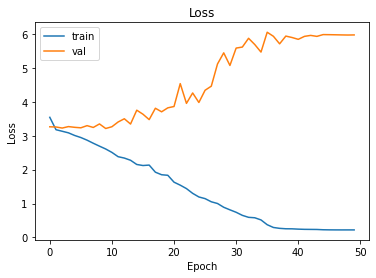

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss_history)
plt.plot(test_loss_history)
plt.legend(["train", "val"])
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

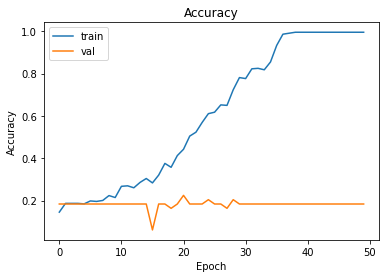

In [ ]:
plt.plot(train_acc_history)
plt.plot(test_acc_history)
plt.legend(["train", "val"])
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

#### Generate Next 200 Characters from Input Sequence of 25 Characters

In [ ]:
def generate_text(test_sample, n):
    input_text = test_sample
    generated_text = ''
    with torch.no_grad():
        for i in range(n):
            x_test = torch.tensor([[char_to_ix[ch] for ch in input_text]])
            x_test = F.one_hot(x_test, num_classes=vocab_size)
            x_test = x_test.transpose(1, 2)
            output = model(x_test.float())
            _, predictions = torch.max(output, 1)
            char_pred = ix_to_char[predictions[0].item()]
            generated_text += char_pred
            input_text = input_text[1:] + char_pred

    return test_sample + generated_text

In [ ]:
test_sample = 'she walked down the steps'
print(generate_text(test_sample, 200))

test_sample = 'Chios island is crescent ' 
print(generate_text(test_sample, 200))

she walked down the steps          r o ii d a d oes aod kides  os  ,      ,, an eao id add sif to ir o s oe ess and wekik wiee (th of thes sand seesi ei e ioo  rok ksnnn nnns h h he moes rrirs rrano iountain  n  ng the srrnae
Chios island is crescent or kidney shaped, 50 km (31 mi) long from north to south, and 29 km (18 mi) at its widest, covering an area of 8422289 km2 (325.210 sq mi).[2] The terrain is mountainous and arid, with a ridge of moun


We can see that our model has fully memorized the training data, and if given the exact first 25 characters of the text sample it will generate the rest on its own. However, it generalizes poorly on unseen data, and is capable of producing very few word from english, the rest being just gibberish.